**Importing dependencies**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import platform
import pathlib
import os

import tensorflow.keras as keras
import tensorflow.keras.backend as K 

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec, Input
from tensorflow.keras.layers import Add, Activation, concatenate
from tensorflow.keras.layers import Conv2D, Dropout 
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#-------------------------------------------------------------------------------
import skimage.io
from skimage.transform import  resize, rotate
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import f1_score,cohen_kappa_score,roc_auc_score
from sklearn.metrics import  classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import itertools 

**Parameters to change for each model**

In [ ]:
Num_classes = 4
IMG_SIZE = 224
batchsize = 16
img_height = 224
img_width = 224
initial_epochs = 35
final_epoch = 50
#resume_epoch = initial_epochs
BaseLearningRate = 1e-3
class_names = ['impala', 'other', 'warthog', 'zebra']

In [ ]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

# ==>update the optimizer in the compile command

# set save path 
saveModelPath ='/content/drive/MyDrive/A_ClassifierModels/'
modelName = 'MobileNetV2_optimizer_RMSprop'

# Set path for model checkpoints
checkpoint_filepath = saveModelPath+'ModelCheckpoints/'+ modelName+'/'


# Check whether the specified path exists or not
isExist = os.path.exists(checkpoint_filepath)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(checkpoint_filepath)
  print("The new directory is created!")
  print(checkpoint_filepath)

The new directory is created!
/content/drive/MyDrive/A_ClassifierModels/ModelCheckpoints/MobileNetV2_optimizer_RMSprop/


**Prepare data for training**

Generate batches of tensor image data with real-time data augmentation.



```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```



[flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

Takes the path to a directory & generates batches of augmented data.



```
flow_from_directory(
    directory, target_size=(256, 256), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, subset=None, interpolation='nearest'
)
```



In [ ]:
"""Prepare Data For Retraining"""

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    shear_range=0.15,
    brightness_range= [0.5, 1.5],
    validation_split=0.1,) # set validation split

train_generator = train_datagen.flow_from_directory(
   '/content/drive/MyDrive/THREE_CLASSES+1/TRAIN',
    target_size=(img_height, img_width),
    batch_size=batchsize,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/THREE_CLASSES+1/TRAIN',
    target_size=(img_height, img_width),
    batch_size=batchsize,
    class_mode='categorical',
    subset='validation') # set as validation data
validation_generator.class_indices

Found 5864 images belonging to 4 classes.
Found 650 images belonging to 4 classes.


{'impala': 0, 'other': 1, 'warthog': 2, 'zebra': 3}

**Constructing the NASNetMobile Model with freezed base model**

Use model from [Keras Applications](https://keras.io/api/applications/)

In [ ]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    #inputs = data_augmentation(inputs)
    
    base_model = MobileNetV2(input_tensor=inputs, 
                             weights='imagenet', 
                             include_top=False, 
                             alpha=1)

    base_model.trainable = False
    # Create new model on top
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    # add a global spatial average pooling layer
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

    # Classification layer or output layer
    outputs = keras.layers.Dense(4, activation='softmax')(x)

    # this is the model we will train
    model = keras.Model(inputs, outputs)
    return model

**Compile the model**

[Optimizers](https://keras.io/api/optimizers/)=(RMSprop, Adam,Adagrad)

1.   opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
2.   opt = tf.keras.optimizers.Adam(learning_rate=0.01)
3.   opt = tf.keras.optimizers.Nadam(learning_rate=0.001)




In [ ]:
model = model()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                

**Train the model with freezed base**

[From github page](https://github.com/keras-team/keras/issues/12511). The EarlyStopping callback will, if the ***restore_best_weights*** option is True, restore the best weights if and only if it requests the stopping itself, not if stopping is requested by another callback or the training loop has simply run for a given number of epochs. The call to Model.***set_weights*** is inside the ***on_epoch_end*** method guarded by a comparison of wait and patience.

I've been doing this as a workaround... Its a little inelegant, but seems to work for my use-cases.

1.   Use the ModelCheckpoint callback with **save_best_only=True**.
2.   After training, load the best model using **tf.keras.models.load_model**.

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved


*   **save_best_only:** if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
*   **save_weights_only:** if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).



```
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    **kwargs
)
```




In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]
    
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.    
history1 = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/35
367/367 [==============================] - 1791s 5s/step - loss: 0.1813 - accuracy: 0.9384 - val_loss: 0.3490 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 2/35
367/367 [==============================] - 104s 283ms/step - loss: 0.0768 - accuracy: 0.9756 - val_loss: 0.4014 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 3/35
367/367 [==============================] - 104s 282ms/step - loss: 0.0629 - accuracy: 0.9797 - val_loss: 0.4470 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 4/35
367/367 [==============================] - 104s 283ms/step - loss: 0.0548 - accuracy: 0.9811 - val_loss: 0.3877 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 5/35
367/367 [==============================] - 105s 285ms/step - loss: 0.0401 - accuracy: 0.9865 - val_loss: 0.3427 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 6/35
367/367 [==============================] - 104s 284ms/step - loss: 0.0453 - accuracy: 0.9845 - val_loss: 0.3623 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 7/35
367/367 [====================

**Store the history variables**

In [ ]:
"""Visualizing the training and Validation performance"""
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

resume_epoch = len(acc1)
print('resume_epoch =')
print(resume_epoch)

resume_epoch =
26


**Fine Tuning-Unfreeze the base_model**

Let the layers of the base model be trainable

In [ ]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    #inputs = data_augmentation(inputs)
    
    base_model = MobileNetV2(input_tensor=inputs, 
                             weights=None, 
                             include_top=False, 
                             alpha=1)

    # Unfreeze the base_model. Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we've done so far.
    base_model.trainable = True
    # Create new model on top
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    # add a global spatial average pooling layer
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

    # Classification layer or output layer
    outputs = keras.layers.Dense(4, activation='softmax')(x)

    # this is the model we will train
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = model()
# The model weights (that are considered the best) are loaded into the model
# before continuing to train
model.load_weights(checkpoint_filepath)
print('Weights from model checkpoint loaded')
model.summary()

Weights from model checkpoint loaded
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_None (Func  (None, 7, 7, 1280)       2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,10

**Compile the model again**

In [ ]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

How to set up **model.fit** to resume training from last Epoch. [Check this](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

```
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
```

Update the **initial_epoch=0** to a value that corresponds to the last training epoch



In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]


# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history2 = model.fit(train_generator,
                    epochs=final_epoch,
                    initial_epoch = resume_epoch,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 27/50
367/367 [==============================] - 124s 314ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.3411 - val_accuracy: 0.9015 - lr: 1.0000e-06
Epoch 28/50
367/367 [==============================] - 115s 314ms/step - loss: 0.0335 - accuracy: 0.9877 - val_loss: 0.3817 - val_accuracy: 0.9108 - lr: 1.0000e-06
Epoch 29/50
367/367 [==============================] - 115s 313ms/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 0.3750 - val_accuracy: 0.9108 - lr: 1.0000e-06
Epoch 30/50
367/367 [==============================] - 114s 312ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.3775 - val_accuracy: 0.9154 - lr: 1.0000e-06
Epoch 31/50
367/367 [==============================] - 115s 314ms/step - loss: 0.0266 - accuracy: 0.9916 - val_loss: 0.3822 - val_accuracy: 0.9169 - lr: 1.0000e-07
Epoch 32/50
367/367 [==============================] - 115s 312ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.3917 - val_accuracy: 0.9123 - lr: 1.0000e-07
Epoch 33/50
367/

Combine the histories of the two training sections.

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

acc = [*acc1,*acc2] # unpack both iterables in a list literal
val_acc = [*val_acc1,*val_acc2]
loss = [*loss1,*loss2]
val_loss =[*val_loss1,*val_loss2]


**which epoch has the minimum validation loss?**


In [ ]:
#Find the minimum value of val_loss
min_val_loss = min(val_loss)
print('Minimum Validation loss = ')
print(min_val_loss)

#Find the index of the minimum value in val_loss
index_of_min_in_val_loss = val_loss.index(min_val_loss)
best_epoch = index_of_min_in_val_loss+1
print('Epoch with the minimum validation loss = ')
print(best_epoch)

Minimum Validation loss = 
0.32315173745155334
Epoch with the minimum validation loss = 
16


**Visualizing the training and Validation performance**

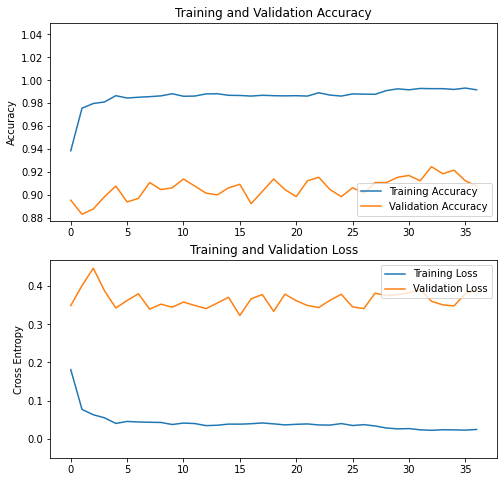

In [ ]:
"""Visualizing the training and Validation performance"""
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-0.05,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**Save the trainedmodel**

we save both weights in .h5 file and also save the entire model

In [ ]:
fineTune_epoch = len(acc2);
# if early stopping happened, automatically best weights are restored, however
# if training completed, then load best weights from model checkpoint path
if fineTune_epoch >=(final_epoch-resume_epoch):
  # The model weights (that are considered the best) are loaded into the model.
  model.load_weights(checkpoint_filepath)
  print('Weights from model checkpoint loaded')

# Save the model
saveFolderPath = saveModelPath+'SavedModels/'+modelName
model.save(saveFolderPath)
model.save(saveFolderPath+'.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/A_ClassifierModels/SavedModels/MobileNetV2_optimizer_RMSprop/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


**Apply some test images**

Load model

In [ ]:
#saved_model_path = saveModelPath+modelName
new_model = tf.keras.models.load_model(saveFolderPath)

# Check its architecture
new_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_None (Func  (None, 7, 7, 1280)       2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,228,996
Non-tra

In [ ]:
"""Prepare Data For TESTING"""
batchsize = 20
img_height = 224
img_width = 224
# (img_height,img_width)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/THREE_CLASSES+1/TEST',
        target_size=(img_height,img_width),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
# put shuffle=False when you do test_datagen.flow_from_directory() so the 
# samples don't get shuffled and have the same order as test_generator.classes 

Found 200 images belonging to 4 classes.


In [ ]:

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Perform predictions
Y_pred = new_model.predict(test_generator)

# Pick prediction as the class with highest probability
y_pred = np.argmax(Y_pred, axis=1)

# Display the classifications report
print('Classification Report')
target_names = class_names
cr = classification_report(test_generator.classes, y_pred, target_names=target_names)
print(cr)

Classification Report
              precision    recall  f1-score   support

      impala       0.96      0.98      0.97        50
       other       0.96      0.98      0.97        50
     warthog       0.98      0.94      0.96        50
       zebra       1.00      1.00      1.00        50

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



Confusion matrix, without normalization


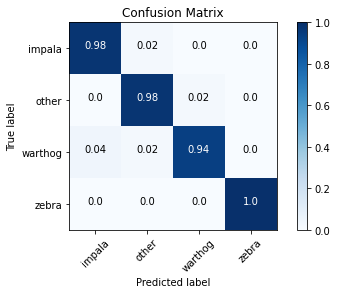

In [ ]:
#get confusion_matrix, set normalize{‘true’
cm = confusion_matrix(test_generator.classes, y_pred,normalize='true')
cm = np.around(cm, decimals=2)

#Next, we define the labels for the confusion matrix. 
cm_plot_labels = ['impala', 'other', 'warthog', 'zebra']

# Lastly, we plot the confusion matrix by using the plot_confusion_matrix() 
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**display some sample test images and the prediction values**

200


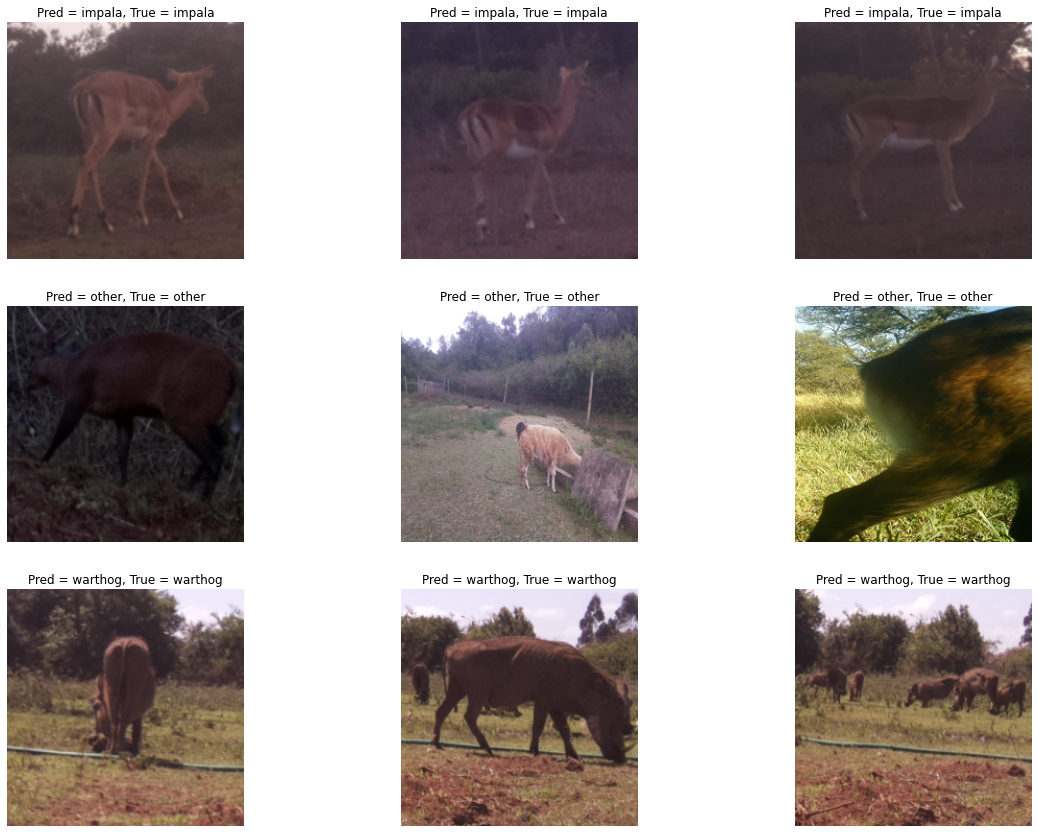

In [ ]:
# Get the list of all files in directory tree at given path
listOfFiles = test_generator._filepaths
y_pred_class_codes=y_pred
print(len(listOfFiles))
i_max = 9 # it should match the number of images in the subplot figure
i = 0
k = 0
plt.figure(figsize=(20, 20))
while i < i_max:
  image_path = listOfFiles[k]
  pred_label = class_names[int(y_pred_class_codes[k])]
  true_label = class_names[int(test_generator.classes[k])]
  #print('The prediced species is: %s' %pred_label)
  #img = cv2.imread(image_path)
  img= skimage.io.imread(image_path,plugin='imageio')
  
  # Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in 
  # RGB mode. So color images will not be displayed correctly in Matplotlib if 
  # image is read with OpenCV. 

  # Convert BGR to RGB with OpenCV function cvtColor()
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(4, 3, i + 1)
  plt.imshow(img)
  plt.title('Pred = ' + pred_label +', True = '+true_label)
  plt.axis("off")

  i = i+1
  k = k+17   # add number not greater than len(listOfFiles)/i_max

**Find mis-predicted files**

200
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a


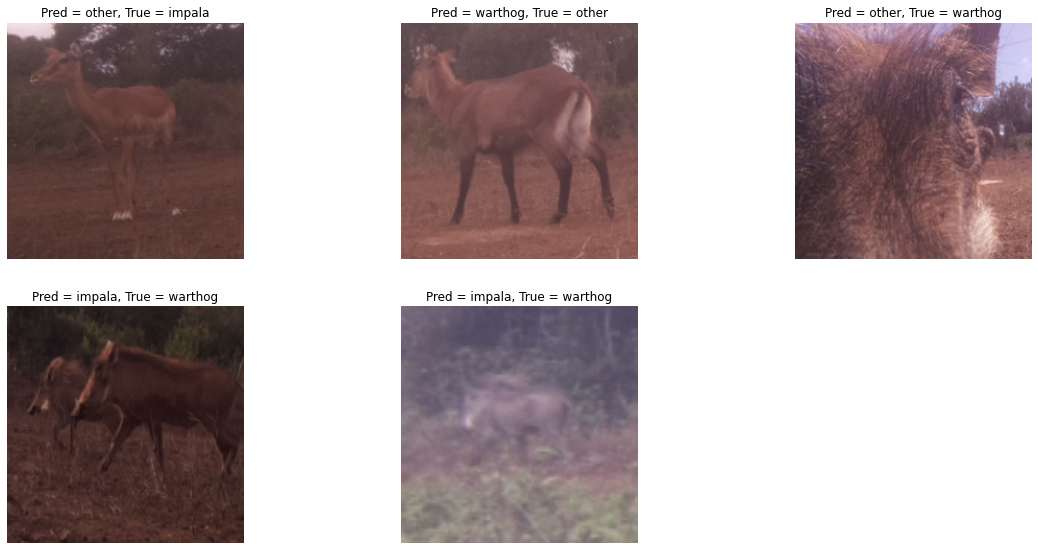

In [ ]:
# Get the list of all files in directory tree at given path
listOfFiles = test_generator._filepaths
y_pred_class_codes=y_pred
print(len(listOfFiles))
i_max = len(listOfFiles) 
i = 0
k = 0
plt.figure(figsize=(20, 20))
while i < i_max:
  image_path = listOfFiles[i]
  pred_label = class_names[int(y_pred_class_codes[i])]
  true_label = class_names[int(test_generator.classes[i])]

  # identify miscalculated images
  if pred_label != true_label:
    print("b is greater than a")
    #print('The prediced species is: %s' %pred_label)
    #img = cv2.imread(image_path)
    img= skimage.io.imread(image_path,plugin='imageio')
    
    # Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in 
    # RGB mode. So color images will not be displayed correctly in Matplotlib if 
    # image is read with OpenCV. 

    # Convert BGR to RGB with OpenCV function cvtColor()
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 3, k + 1)
    plt.imshow(img)
    plt.title('Pred = ' + pred_label +', True = '+true_label)
    plt.axis("off")    
    k = k+1   # add number not greater than len(listOfFiles)/i_max
  if k>8:
    break
  i = i+1